In [321]:
import os
import pandas as pd
import numpy as np

from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, roc_auc_score, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Activation, Dense, Conv2D, MaxPool2D,MaxPooling2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image

import warnings
warnings.filterwarnings('ignore')
import splitfolders

In [190]:
parasitized= r'C:Downloads/VS/MALARIA PROJECT FOLDER/cell_images/Parasitized'
uninfected= r'C:Downloads/VS/MALARIA PROJECT FOLDER/cell_images/uninfected'


In [192]:
print('parasitized lenght:', len(os.listdir(parasitized)))
print('uninfected lenght:', len(os.listdir(uninfected)))

parasitized lenght: 13780
uninfected lenght: 13780


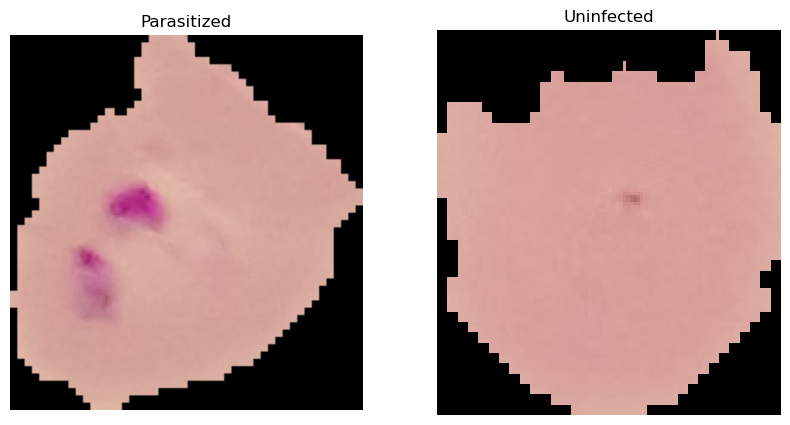

In [194]:
# Paths to the Parasitized and Uninfected folders
parasitized_folder = r'C:/Users/PC/Downloads/VS/MALARIA PROJECT FOLDER/cell_images/Parasitized'
uninfected_folder = r'C:/Users/PC/Downloads/VS/MALARIA PROJECT FOLDER/cell_images/Uninfected'

def display_images_in_row(parasitized_folder, uninfected_folder, index=3):
    def get_image(folder_path, index):
        # List all image files and filter out non-image files
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

        # Ensure the folder contains image files and the index is valid
        if len(image_files) > 0 and index < len(image_files):
            # Return the image path
            image_path = os.path.join(folder_path, image_files[index])
            return Image.open(image_path)
        else:
            print(f"No image files found or invalid index.")
            return None

    # Get the images from both folders
    parasitized_image = get_image(parasitized_folder, index)
    uninfected_image = get_image(uninfected_folder, index)

    # Display the images side by side
    if parasitized_image and uninfected_image:
        plt.figure(figsize=(10, 5))  # Set figure size for both images
        # Show first image
        plt.subplot(1, 2, 1)  # 1 row, 2 columns, first image
        plt.imshow(parasitized_image)
        plt.title("Parasitized")
        plt.axis('off')  # Hide axis

        # Show second image
        plt.subplot(1, 2, 2)  # 1 row, 2 columns, second image
        plt.imshow(uninfected_image)
        plt.title("Uninfected")
        plt.axis('off')  # Hide axis

        plt.show()

# Display the images in the same row
display_images_in_row(parasitized_folder, uninfected_folder, index=3)



In [208]:
data_dir = r'C:Downloads/VS/MALARIA PROJECT FOLDER/cell_images'
filepaths = []
labels = []

# Collect file paths and labels
folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Create DataFrame
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

In [210]:
# Split data into training, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['labels'], random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.2, stratify=test_df['labels'], random_state=42)

In [212]:
from tensorflow.keras import layers, models

# Build a simple CNN model
model = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3), padding ='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), padding ='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3), padding ='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu', input_shape=(224, 224, 3), padding ='same'),
    layers.BatchNormalization(), 
    layers.MaxPooling2D(2, 2),
    
    layers.Flatten(),
    
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(1, activation='sigmoid')  # Binary classification
    
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_43 (Conv2D)              │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 32)             │       802,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 901,281 (3.44 MB)

 Trainable params: 900,801 (3.44 MB)

 Non-trainable params: 480 (1.88 KB)

In [214]:
# Image Data Generator for loading images
datagen = ImageDataGenerator(rescale=1./255)

# Training data generator
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    class_mode='binary',  # Assuming binary classification
    batch_size=32
)

# Validation data generator
val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

# Test data generator
test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    shuffle=False
)


Found 22047 validated image filenames belonging to 2 classes.
Found 4408 validated image filenames belonging to 2 classes.
Found 1103 validated image filenames belonging to 2 classes.


In [216]:
# Convert the labels to a NumPy array
y_train = train_df['labels'].to_numpy()

# Compute the class weights based on the label distribution
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Convert to dictionary form (Keras expects class weights as a dictionary)
class_weight_dict = dict(enumerate(class_weights))

# Define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5)

class_weight_dict 

{0: 1.0, 1: 1.0}

In [218]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    class_weight=class_weight_dict,  # Important for handling imbalanced data
    callbacks= [early_stop]
)


Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 676s 911ms/step - accuracy: 0.5521 - loss: 0.7428 - val_accuracy: 0.8167 - val_loss: 0.4165
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 626s 907ms/step - accuracy: 0.8677 - loss: 0.3705 - val_accuracy: 0.9467 - val_loss: 0.1576
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 621s 900ms/step - accuracy: 0.9179 - loss: 0.2796 - val_accuracy: 0.9542 - val_loss: 0.2403
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 643s 933ms/step - accuracy: 0.9299 - loss: 0.2387 - val_accuracy: 0.9519 - val_loss: 0.1432
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 719s 1s/step - accuracy: 0.9338 - loss: 0.2205 - val_accuracy: 0.9188 - val_loss: 0.1994
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 644s 934ms/step - accuracy: 0.9406 - loss: 0.1832 - val_accuracy: 0.9410 - val_loss: 0.1725
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 675s 979ms/step - accuracy: 0.9472 - loss: 0.1714 - val_accuracy: 0.9594 - val_loss: 0.1358
Epoch 8/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 632s 916ms/step - accuracy: 0.9494 - lo

In [220]:
# For evaluation:
test_loss, test_acc = model.evaluate(test_generator)

35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 279ms/step - accuracy: 0.9468 - loss: 0.1597


In [508]:
# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(val_generator)

138/138 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step - accuracy: 0.9394 - loss: 0.1637


In [228]:
history

In [230]:
history.params

{'verbose': 'auto', 'epochs': 10, 'steps': 689}

In [232]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [506]:
history.history['val_accuracy']

[0.9348911046981812,
 0.9485027194023132,
 0.9512250423431396,
 0.9351179599761963,
 0.9410163164138794]

In [234]:
history.history['accuracy']

[0.6286116242408752,
 0.8901438117027283,
 0.9224384427070618,
 0.9299224615097046,
 0.9358189105987549,
 0.9431214928627014,
 0.946976900100708,
 0.9497437477111816,
 0.9493808746337891,
 0.9511498212814331]

In [236]:
history.history['loss']

[0.6115656495094299,
 0.3349088132381439,
 0.26641398668289185,
 0.23478397727012634,
 0.2132207304239273,
 0.18413561582565308,
 0.1679145097732544,
 0.15797793865203857,
 0.15138088166713715,
 0.14978213608264923]

In [238]:
history.history['val_loss'] 

[0.41653701663017273,
 0.15755325555801392,
 0.2403315007686615,
 0.14324738085269928,
 0.19940663874149323,
 0.17245790362358093,
 0.1358357071876526,
 0.1448746770620346,
 0.15237551927566528,
 0.13615582883358002]

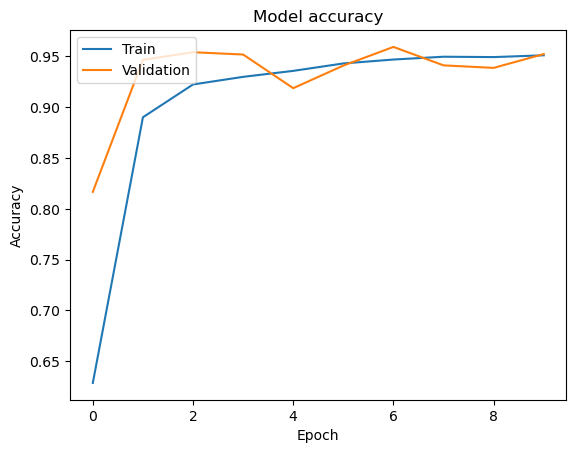

In [242]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

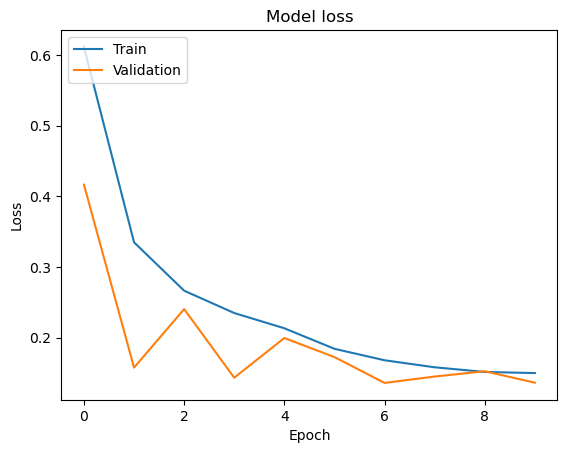

In [244]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [246]:
# Predicted probabilities from the model
pred_probabilities = model.predict(test_generator)
threshold = 0.5
predictions = pred_probabilities > threshold

# Evaluate performance at this threshold
print(classification_report(test_generator.classes, predictions))


35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 218ms/step
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       552
           1       0.92      0.99      0.95       551

    accuracy                           0.95      1103
   macro avg       0.95      0.95      0.95      1103
weighted avg       0.95      0.95      0.95      1103



In [248]:
confusion_matrix(test_generator.classes, predictions)

array([[502,  50],
       [  6, 545]], dtype=int64)

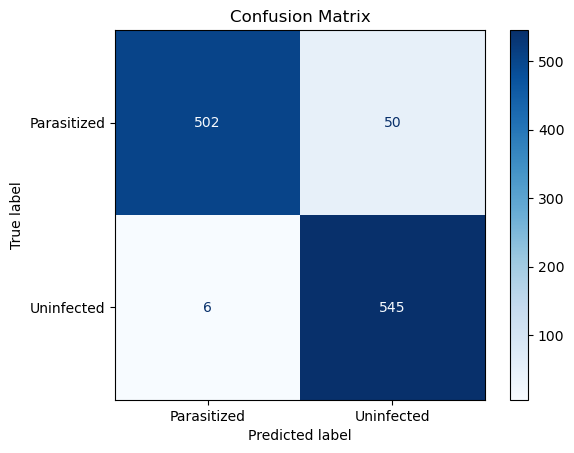

In [302]:
# The confusion matrix
cm = confusion_matrix(test_generator.classes, predictions)

# Extract the labels directly from class_indices (no need for conditional checks)
labels = list(test_generator.class_indices.keys())

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

# Adding title and showing the plot
plt.title('Confusion Matrix')
plt.show()

35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 227ms/step


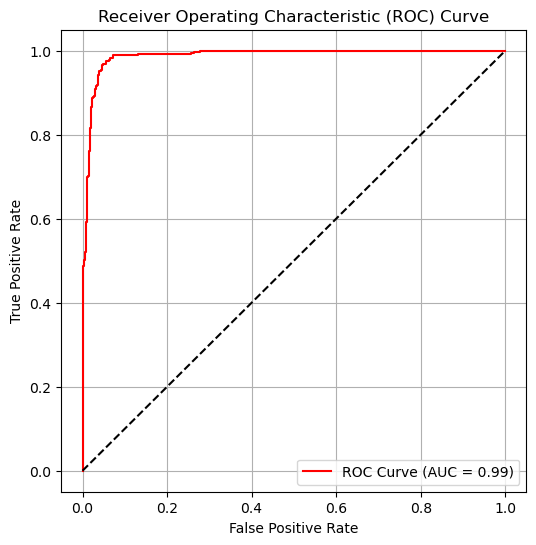

In [304]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you have the true labels and predicted probabilities
y_true = test_generator.classes  # Actual class labels
y_prob = model.predict(test_generator)  # Predicted probabilities from the model

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_prob)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='red', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')  # Diagonal line for random performance
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [309]:
from tensorflow.keras.saving import save_model

save_model(model, 'malaria_model.keras')

# Transfer Learning Models

In [423]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


# Training data generator
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    class_mode='binary',  # Assuming binary classification
    batch_size=32
)

# Validation data generator
val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

# Test data generator
test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    shuffle=False
)


Found 22047 validated image filenames belonging to 2 classes.
Found 4408 validated image filenames belonging to 2 classes.
Found 1103 validated image filenames belonging to 2 classes.


# RESNET50

In [425]:
from tensorflow.keras.applications import ResNet50

# Load the ResNet50 model with pre-trained weights, excluding the top layers
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers
resnet50_base.trainable = False

# Add custom top layers
resnet50_model = models.Sequential([
    resnet50_base,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
resnet50_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
resnet50_model.summary()


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_31 (Flatten)            │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,278,337 (187.98 MB)

 Trainable params: 25,690,625 (98.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [427]:
# Train the model
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    class_weight=class_weight_dict,  # if class imbalance is present
    callbacks=[early_stop]
)


Epoch 1/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 778s 1s/step - accuracy: 0.9280 - loss: 0.2140 - val_accuracy: 0.9383 - val_loss: 0.1829
Epoch 2/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 774s 1s/step - accuracy: 0.9266 - loss: 0.2206 - val_accuracy: 0.9142 - val_loss: 0.2213
Epoch 3/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 773s 1s/step - accuracy: 0.9284 - loss: 0.2125 - val_accuracy: 0.9419 - val_loss: 0.1720
Epoch 4/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 768s 1s/step - accuracy: 0.9317 - loss: 0.2019 - val_accuracy: 0.9462 - val_loss: 0.1624
Epoch 5/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 773s 1s/step - accuracy: 0.9295 - loss: 0.2056 - val_accuracy: 0.9424 - val_loss: 0.1631


In [429]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)

35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 493ms/step - accuracy: 0.9374 - loss: 0.1832


In [510]:
# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(val_generator)

138/138 ━━━━━━━━━━━━━━━━━━━━ 89s 647ms/step - accuracy: 0.9461 - loss: 0.1608


In [431]:
# Get predicted probabilities
pred_probabilities = model.predict(test_generator)
threshold = 0.5
predictions = pred_probabilities > threshold

# Evaluate performance
print(classification_report(test_generator.classes, predictions))

35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 500ms/step
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       552
           1       0.90      0.98      0.94       551

    accuracy                           0.94      1103
   macro avg       0.94      0.94      0.94      1103
weighted avg       0.94      0.94      0.94      1103



In [439]:
# Confusion matrix
cm = confusion_matrix(test_generator.classes, predictions)
cm

array([[495,  57],
       [ 13, 538]], dtype=int64)

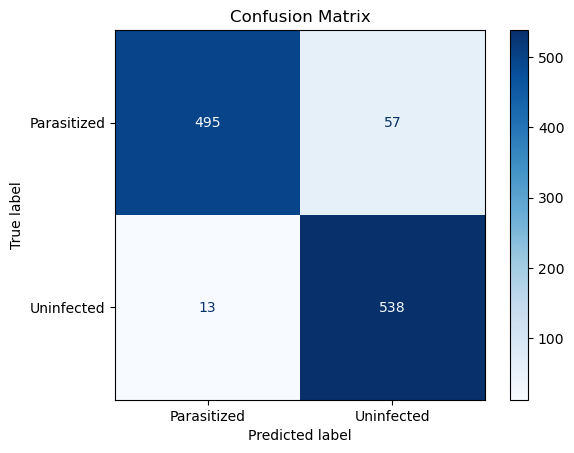

In [441]:
# Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


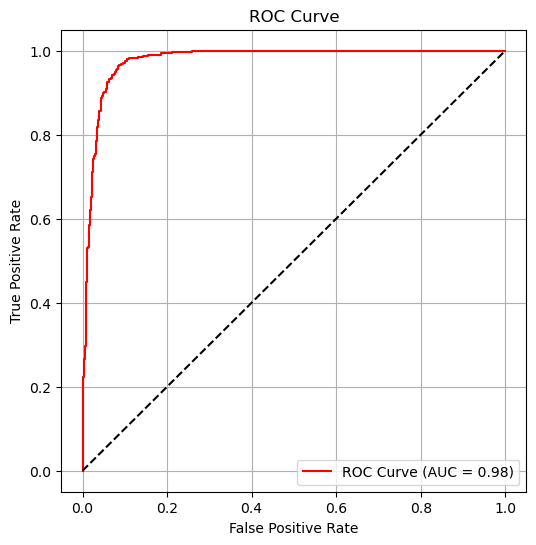

In [443]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(test_generator.classes, pred_probabilities)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='red')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# VGG16

In [478]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

# Load the VGG16 model with pre-trained weights, excluding the top layers
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers
vgg16_base.trainable = False

# Add custom top layers
vgg16_model = models.Sequential([
    vgg16_base,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
vgg16_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
vgg16_model.summary()


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_35 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [480]:
# Train the model
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    class_weight=class_weight_dict,  # if class imbalance is present
)

Epoch 1/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 1040s 2s/step - accuracy: 0.9377 - loss: 0.1861 - val_accuracy: 0.9449 - val_loss: 0.1582
Epoch 2/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 794s 1s/step - accuracy: 0.9374 - loss: 0.1887 - val_accuracy: 0.9453 - val_loss: 0.1607
Epoch 3/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 783s 1s/step - accuracy: 0.9383 - loss: 0.1850 - val_accuracy: 0.9406 - val_loss: 0.1673
Epoch 4/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 778s 1s/step - accuracy: 0.9390 - loss: 0.1824 - val_accuracy: 0.9283 - val_loss: 0.1807
Epoch 5/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 787s 1s/step - accuracy: 0.9385 - loss: 0.1865 - val_accuracy: 0.9524 - val_loss: 0.1559


In [481]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)

35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 490ms/step - accuracy: 0.9446 - loss: 0.1830


In [511]:
# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(val_generator)

138/138 ━━━━━━━━━━━━━━━━━━━━ 81s 590ms/step - accuracy: 0.9427 - loss: 0.1640


In [482]:
# Get predicted probabilities
pred_probabilities = model.predict(test_generator)
threshold = 0.5
predictions = pred_probabilities > threshold

# Evaluate performance
print(classification_report(test_generator.classes, predictions))

35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 502ms/step
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       552
           1       0.91      0.97      0.94       551

    accuracy                           0.94      1103
   macro avg       0.94      0.94      0.94      1103
weighted avg       0.94      0.94      0.94      1103



In [483]:
# Confusion matrix
cm = confusion_matrix(test_generator.classes, predictions)
cm

array([[501,  51],
       [ 15, 536]], dtype=int64)

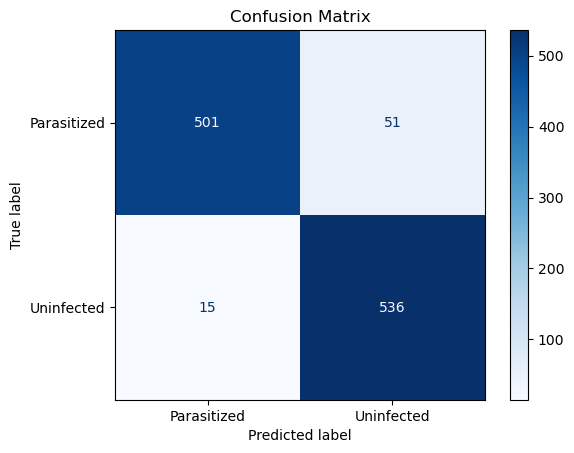

In [484]:
# Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

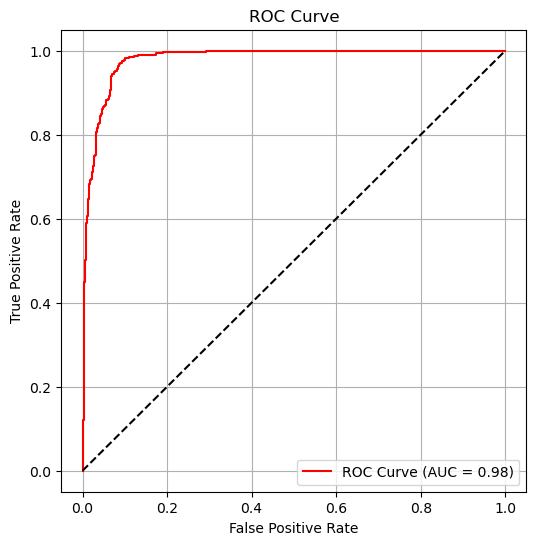

In [485]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(test_generator.classes, pred_probabilities)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='red')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# INCEPTIONV3

In [486]:
from tensorflow.keras.applications import InceptionV3

# Load the InceptionV3 model with pre-trained weights, excluding the top layers
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers
inception_base.trainable = False

# Add custom top layers
inception_model = models.Sequential([
    inception_base,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
inception_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
inception_model.summary()


Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_36 (Flatten)            │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 256)            │    13,107,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,910,497 (133.17 MB)

 Trainable params: 13,107,713 (50.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [487]:
# Train the model
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    class_weight=class_weight_dict,  # if class imbalance is present
)

Epoch 1/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 790s 1s/step - accuracy: 0.9418 - loss: 0.1776 - val_accuracy: 0.9349 - val_loss: 0.1621
Epoch 2/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 801s 1s/step - accuracy: 0.9370 - loss: 0.1874 - val_accuracy: 0.9485 - val_loss: 0.1598
Epoch 3/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 777s 1s/step - accuracy: 0.9432 - loss: 0.1763 - val_accuracy: 0.9512 - val_loss: 0.1578
Epoch 4/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 777s 1s/step - accuracy: 0.9405 - loss: 0.1784 - val_accuracy: 0.9351 - val_loss: 0.1733
Epoch 5/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 822s 1s/step - accuracy: 0.9373 - loss: 0.1786 - val_accuracy: 0.9410 - val_loss: 0.1593


In [520]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)

35/35 ━━━━━━━━━━━━━━━━━━━━ 22s 636ms/step - accuracy: 0.9314 - loss: 0.1910


In [512]:
# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(val_generator)

138/138 ━━━━━━━━━━━━━━━━━━━━ 81s 583ms/step - accuracy: 0.9469 - loss: 0.1547


In [518]:
# Get predicted probabilities
pred_probabilities = model.predict(test_generator)
threshold = 0.5
predictions = pred_probabilities > threshold

# Evaluate performance
print(classification_report(test_generator.classes, predictions))

35/35 ━━━━━━━━━━━━━━━━━━━━ 22s 639ms/step
              precision    recall  f1-score   support

           0       0.98      0.89      0.93       552
           1       0.90      0.98      0.94       551

    accuracy                           0.94      1103
   macro avg       0.94      0.94      0.94      1103
weighted avg       0.94      0.94      0.94      1103



In [489]:
# Confusion matrix
cm = confusion_matrix(test_generator.classes, predictions)
cm

array([[501,  51],
       [ 15, 536]], dtype=int64)

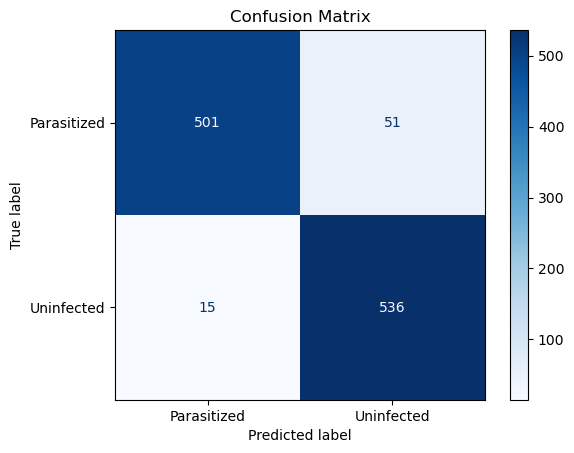

In [490]:
# Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

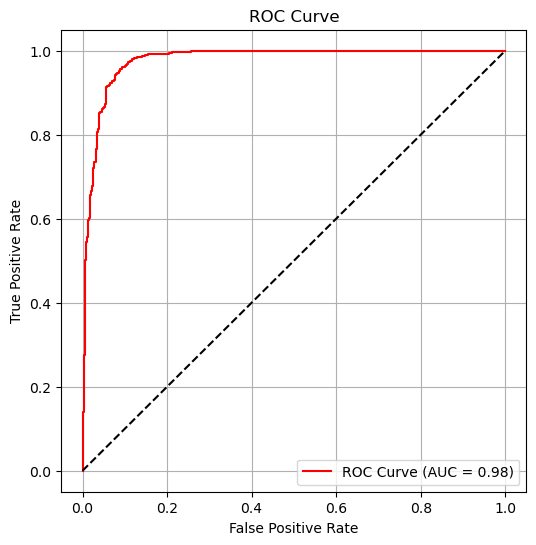

In [462]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(test_generator.classes, pred_probabilities)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='red')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# EFFICIENTNETB0

In [464]:
from tensorflow.keras.applications import EfficientNetB0

# Load the EfficientNetB0 model with pre-trained weights, excluding the top layers
efficientnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers
efficientnet_base.trainable = False

# Add custom top layers
efficientnet_model = models.Sequential([
    efficientnet_base,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
efficientnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
efficientnet_model.summary()

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_34 (Flatten)            │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 256)            │    16,056,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,106,404 (76.70 MB)

 Trainable params: 16,056,833 (61.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [468]:
# Train the model
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    class_weight=class_weight_dict,  # if class imbalance is present
)

Epoch 1/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 800s 1s/step - accuracy: 0.9377 - loss: 0.1866 - val_accuracy: 0.9399 - val_loss: 0.1607
Epoch 2/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 788s 1s/step - accuracy: 0.9357 - loss: 0.1908 - val_accuracy: 0.9358 - val_loss: 0.1811
Epoch 3/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 783s 1s/step - accuracy: 0.9365 - loss: 0.1927 - val_accuracy: 0.9494 - val_loss: 0.1634
Epoch 4/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 783s 1s/step - accuracy: 0.9423 - loss: 0.1780 - val_accuracy: 0.9462 - val_loss: 0.1717
Epoch 5/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 784s 1s/step - accuracy: 0.9376 - loss: 0.1932 - val_accuracy: 0.9496 - val_loss: 0.1516


In [470]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)

35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 688ms/step - accuracy: 0.9459 - loss: 0.1729


In [513]:
# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(val_generator)

138/138 ━━━━━━━━━━━━━━━━━━━━ 90s 655ms/step - accuracy: 0.9450 - loss: 0.1669


In [522]:
# Get predicted probabilities
pred_probabilities = model.predict(test_generator)
threshold = 0.5
predictions = pred_probabilities > threshold

# Evaluate performance
print(classification_report(test_generator.classes, predictions))

35/35 ━━━━━━━━━━━━━━━━━━━━ 23s 656ms/step
              precision    recall  f1-score   support

           0       0.97      0.89      0.93       552
           1       0.90      0.98      0.94       551

    accuracy                           0.93      1103
   macro avg       0.94      0.93      0.93      1103
weighted avg       0.94      0.93      0.93      1103



In [472]:
# Confusion matrix
cm = confusion_matrix(test_generator.classes, predictions)
cm

array([[465,  87],
       [  4, 547]], dtype=int64)

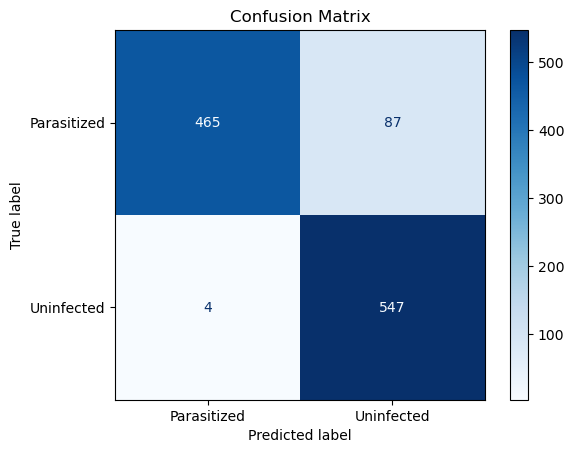

In [474]:
# Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

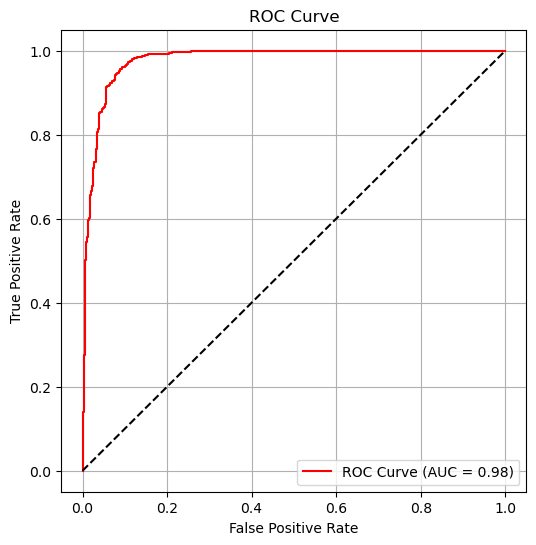

In [476]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(test_generator.classes, pred_probabilities)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='red')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# COMPARE MODEL PERFORMANCE

In [526]:
import pandas as pd

data = {
    'Test': ['Manuel CNN', 'ResNet50', 'VGG16', 'INCEPTIONV3', 'EfficientNetB0'],
    'Accuracy Score': [0.95, 0.94, 0.94, 0.92, 0.95],
    'Val_Accuracy': [0.94, 0.95, 0.94, 0.95, 0.95]
}

df = pd.DataFrame(data)
print(df)




             Test  Accuracy Score  Val_Accuracy
0      Manuel CNN            0.95          0.94
1        ResNet50            0.94          0.95
2           VGG16            0.94          0.94
3     INCEPTIONV3            0.92          0.95
4  EfficientNetB0            0.95          0.95


In [528]:
# Transform the dictionary to a DataFrame
results_df = pd.DataFrame(df)

# Sort the DataFrame by 'Accuracy Score' and 'Val_Accuracy'
sorted_results = results_df.sort_values(by=['Accuracy Score', 'Val_Accuracy'], ascending=False)

# Reset the index
sorted_results_reset = sorted_results.reset_index(drop=True)

# Display the sorted and reset DataFrame
print(sorted_results_reset)

             Test  Accuracy Score  Val_Accuracy
0  EfficientNetB0            0.95          0.95
1      Manuel CNN            0.95          0.94
2        ResNet50            0.94          0.95
3           VGG16            0.94          0.94
4     INCEPTIONV3            0.92          0.95


# PREDICT IMAGES

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


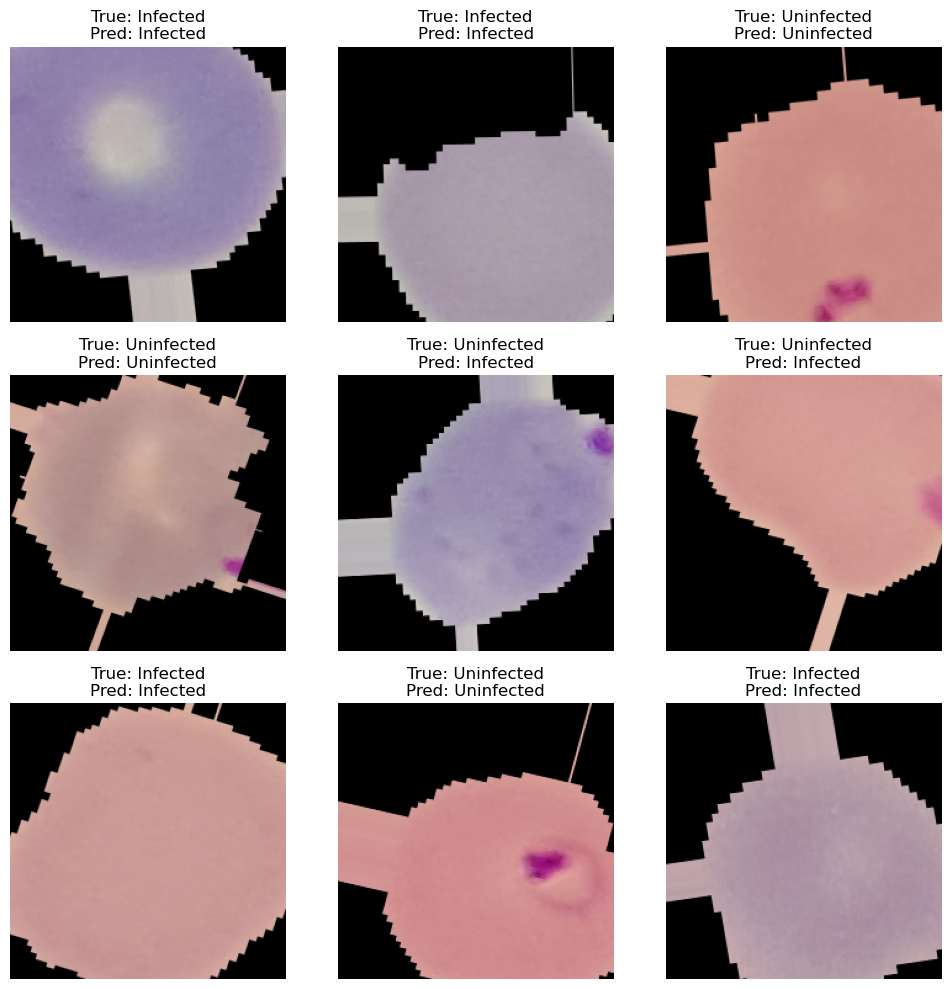

In [563]:
# Load your model
model = load_model('malaria_model.keras')

# Load some images from the test generator (adjust accordingly if using validation generator)
test_images, test_labels = next(test_generator)  # Fetch one batch from test generator

# Make predictions on the batch of images
predictions = model.predict(test_images)
predicted_labels = (predictions > 0.5).astype(int)  # Assuming binary classification (sigmoid output)

# Function to display images along with predicted and true labels
def display_images(images, true_labels, predicted_labels):
    plt.figure(figsize=(10, 10))
    
    for i in range(9):  # Display 9 images (adjust based on batch size)
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        true_label = 'Infected' if true_labels[i] == 1 else 'Uninfected'
        predicted_label = 'Infected' if predicted_labels[i] == 1 else 'Uninfected'
        plt.title(f'True: {true_label}\nPred: {predicted_label}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Display the first 9 images from the batch along with true and predicted labels
display_images(test_images, test_labels, predicted_labels)
